# Advanced SEIQRDV disease spread model tutorial

In this tutorial, we'll explore the advanced SEIQRDV compartmental model which extends SEIR with:
- **Quarantine (Q)**: Movement restrictions for symptomatic individuals
- **Death (D)**: Disease-related mortality
- **Vaccination (V)**: Protective immunity through vaccination

We'll learn:
1. How SEIQRDV differs from basic SEIR
2. How to set up vaccination scenarios
3. How parameters affect disease outcomes
4. How to analyze vaccination effectiveness

**This tutorial focuses on practical usage and parameter effects. For implementation details, see our documentation.**

In [7]:
import simcronomicon as scon
import numpy as np
import plotly.graph_objects as go
import h5py
import os
import glob

## Understanding the SEIQRDV Compartmental Model

The SEIQRDV model extends SEIR with three crucial additions:

### New Compartments
- **Q - Quarantined**: Symptomatic individuals with restricted movement
- **D - Dead**: Disease-related deaths (tracked but removed from simulation)  
- **V - Vaccinated**: Immune individuals through vaccination

### Key Features
- **Priority Places**: Agents actively seek healthcare facilities for vaccination
- **Vaccination Queues**: Limited hospital capacity creates realistic bottlenecks
- **Population Dynamics**: Births/migration and natural deaths
- **Quarantine Behavior**: Infectious agents have restricted movement patterns

In [8]:
# Let's start the simulation at Uniklinik this time!
point = 50.77583, 6.045277
dist = 500 # 500m
town_params = scon.TownParameters(100, 20)  # Dummy
town = scon.Town.from_point(point, dist, town_params)

[1/10] Initializing town object and parameters...
[2/10] Calculating EPSG code...
[3/10] Downloading OSM road network and building data...
[4/10] Processing building geometries...
[5/10] Matching building centroids to nearest road nodes...
[6/10] Classifying buildings...
[7/10] Annotating road graph with place types...
[8/10] Filtering out irrelevant nodes...
[9/10] Building town graph...
Computing shortest paths between filtered nodes...
Adding edges to final town graph...


100%|██████████| 78/78 [00:00<00:00, 44883.48it/s]


[10/10] Saving a compressed graph and config_data...
Town graph successfully built and saved!


Because you can only get vaccinated at hospitals or healthcare facilities, let's see how many of them are there in the current area of interest!

Looking at the plot you can see that there are **4 healthcare facilities**.

In [9]:
# Show the town with healthcare facilities highlighted
town_graph_path = "town_graph.graphmlz"
town_graph_config = "town_graph_config.json"
scon.visualize_place_types_from_graphml(town_graph_path, town_graph_config)

And then let's discuss the model parameters...

## Understanding SEIQRDV Model Parameters

The SEIQRDV model has many parameters that control different aspects of disease spread, vaccination, and population dynamics. Let's explore each one:

### Core Disease Parameters (from SEIR)
- **beta (β)**: Transmission rate - how likely infection spreads between agents
- **gamma**: Incubation period - days from exposure to becoming infectious 
- **max_energy**: Agent energy levels affecting movement patterns

### New SEIQRDV Parameters
- **alpha (α)**: Vaccination desire rate (0-1) - probability agents seek vaccines daily
- **delta (δ)**: Days until quarantine after becoming infectious
- **lam (λ)**: Recovery time in quarantine (days)
- **rho (ρ)**: Time to death in quarantine (days) 
- **kappa (κ)**: Disease mortality rate (0-1) - fraction who die vs recover
- **hospital_capacity**: Maximum vaccines per healthcare facility per day

### Population Dynamics Parameters  
- **lam_cap**: Population growth rate (births/migration)
- **mu**: Natural death rate (non-disease deaths)

Let's demonstrate how these work with practical examples!

## Vaccination System Demonstration

Let's see how vaccination works by setting **alpha = 1.0**. Vaccination works by setting every agent's `want_vaccine` attribute to `True` (everyone wants vaccines) and add to their attribute of type `list` called `priority_place` a place they can get vaccinated or places with `place_type` `healthcare_facility`. 

With all of that said we will see what happen in the first day of a town where everyone wants vaccine and they only go out once per day:

In [10]:
town_params = scon.TownParameters(100, 1)
town = scon.Town.from_files(config_path=town_graph_config, town_graph_path= town_graph_path, town_params=town_params)

step_events = [
    scon.StepEvent(
        "do_something",
        scon.FolkSEIQRDV.interact,
        scon.EventType.DISPERSE,
        9000,
        ['accommodation']
    )
]

# Test vaccination with maximum desire (alpha = 1.0) and limited capacity
test_params = scon.SEIQRDVModelParameters(
    max_energy=5,
    lam_cap=0.0,         # No population growth for this test
    beta=0.0,            # No transmission for this test  
    alpha=1.0,           # 100% want vaccination!
    gamma=4,             # Standard incubation
    delta=5,             # Standard quarantine delay
    lam=7,               # Recovery time in quarantine
    rho=7,               # Time to death in quarantine
    kappa=0.1,           # 10% mortality rate
    mu=0.0,              # No natural deaths for this test
    hospital_capacity=5   # Limited capacity: only 5 vaccines per facility per day
)

test_model = scon.SEIQRDVModel(test_params, step_events)
test_sim = scon.Simulation(town, test_model, 1)  # Just 1 day
test_sim.run()

print("VACCINATION QUEUE ANALYSIS")
print("=" * 50)

# Find healthcare facilities from the town object
healthcare_nodes = []
for node, data in town.town_graph.nodes(data=True):
    if data.get('place_type') == 'healthcare_facility':
        healthcare_nodes.append(node)

print(f"Healthcare facilities in town: {healthcare_nodes}")
print(f"Total healthcare facilities: {len(healthcare_nodes)}")

with h5py.File("simulation_output.h5", "r") as h5file:
    log = h5file["individual_logs/log"][:]
    summary = h5file["status_summary/summary"][:]
    
    # Look at the first step event (morning_routine)
    first_event = log[(log['timestep'] == 1) & (log['event'] == b"do_something")]
    
    # Count people at each healthcare facility
    healthcare_visitors = {}
    for node in healthcare_nodes:
        healthcare_visitors[node] = 0
    
    for row in first_event:
        if row['status'] != b'I':  # Only non-infectious can seek vaccines
            node = row['address']
            if node in healthcare_nodes:
                healthcare_visitors[node] += 1
    
    print("\nPeople seeking vaccination at each facility:")
    total_seeking = 0
    for node, count in healthcare_visitors.items():
        print(f"  Node {node}: {count} people")
        total_seeking += count
    
    print(f"\nTotal people seeking vaccines: {total_seeking}")
    
    # Check how many actually got vaccinated
    final_status = summary[-1]
    vaccinated = final_status['V']
    
    print(f"People actually vaccinated: {vaccinated}")
    print(f"Hospital capacity per facility: {test_params.hospital_capacity}")
    print(f"Total possible vaccines today: {len(healthcare_nodes)} × {test_params.hospital_capacity} = {len(healthcare_nodes) * test_params.hospital_capacity}")
    
    if vaccinated < total_seeking:
        print(f"Bottleneck: {total_seeking - vaccinated} people couldn't get vaccines due to capacity limits and healthcare facilities nearest to them being too crowded!")
    else:
        print("All vaccine seekers were served!")
    
    # Show which facilities were at capacity
    print(f"\nFacility utilization:")
    for node, visitors in healthcare_visitors.items():
        capacity = test_params.hospital_capacity
        utilization = min(visitors, capacity)
        if visitors > 0:
            print(f"  Node {node}: {utilization}/{capacity} vaccines used ({visitors} wanted)")

[1/3] Decompressing the graphmlz file...
[2/3] Load the config_data...
[3/3] Rebuild the town object...
Town graph successfully built from input files!
Step has been run 1
Status: {'S': 82, 'E': 0, 'Q': 0, 'I': 1, 'R': 0, 'D': 0, 'V': 17}
VACCINATION QUEUE ANALYSIS
Healthcare facilities in town: [26, 32, 40, 53]
Total healthcare facilities: 4

People seeking vaccination at each facility:
  Node 26: 14 people
  Node 32: 2 people
  Node 40: 51 people
  Node 53: 22 people

Total people seeking vaccines: 89
People actually vaccinated: 17
Hospital capacity per facility: 5
Total possible vaccines today: 4 × 5 = 20
Bottleneck: 72 people couldn't get vaccines due to capacity limits and healthcare facilities nearest to them being too crowded!

Facility utilization:
  Node 26: 5/5 vaccines used (14 wanted)
  Node 32: 2/5 vaccines used (2 wanted)
  Node 40: 5/5 vaccines used (51 wanted)
  Node 53: 5/5 vaccines used (22 wanted)


With no spreader at all, if you let the simulation runs on for a couple steps more, you can see that people who wanted vaccine and got them wouldn't go to the hospital anymore and others who want the vaccine will get to also have their turn.

In [11]:
test_sim_longer = scon.Simulation(town, test_model, timesteps=20)
test_sim_longer.run()

Step has been run 1
Status: {'S': 82, 'E': 0, 'Q': 0, 'I': 1, 'R': 0, 'D': 0, 'V': 17}
Step has been run 2
Status: {'S': 67, 'E': 0, 'Q': 0, 'I': 1, 'R': 0, 'D': 0, 'V': 32}
Step has been run 3
Status: {'S': 53, 'E': 0, 'Q': 0, 'I': 1, 'R': 0, 'D': 0, 'V': 46}
Step has been run 4
Status: {'S': 43, 'E': 0, 'Q': 0, 'I': 1, 'R': 0, 'D': 0, 'V': 56}
Step has been run 5
Status: {'S': 33, 'E': 0, 'Q': 1, 'I': 0, 'R': 0, 'D': 0, 'V': 66}
Step has been run 6
Status: {'S': 27, 'E': 0, 'Q': 1, 'I': 0, 'R': 0, 'D': 0, 'V': 72}
Step has been run 7
Status: {'S': 22, 'E': 0, 'Q': 1, 'I': 0, 'R': 0, 'D': 0, 'V': 77}
Step has been run 8
Status: {'S': 17, 'E': 0, 'Q': 1, 'I': 0, 'R': 0, 'D': 0, 'V': 82}
Step has been run 9
Status: {'S': 12, 'E': 0, 'Q': 1, 'I': 0, 'R': 0, 'D': 0, 'V': 87}
Step has been run 10
Status: {'S': 7, 'E': 0, 'Q': 1, 'I': 0, 'R': 0, 'D': 0, 'V': 92}
Step has been run 11
Status: {'S': 2, 'E': 0, 'Q': 1, 'I': 0, 'R': 0, 'D': 0, 'V': 97}
Step has been run 12
Status: {'S': 0, 'E': 

## Population Dynamics: Deaths and Immigration

Unlike basic SEIR models, SEIQRDV includes realistic population changes over time:

### Types of Population Changes
1. **Disease Deaths (D compartment)**: People die from the disease based on mortality rate (κ)
2. **Natural Deaths (μ parameter)**: Background mortality affecting all compartments
3. **Immigration/Births (λ_cap parameter)**: New susceptible people enter the population

### How Population Updates Work
- **Every timestep**: The model calls `update_population()` 
- **Natural deaths**: Each person has μ probability of dying (removed from simulation)
- **Immigration**: New people added based on λ_cap rate (proportional to current population)
- **Disease deaths**: Quarantined people die based on κ parameter and ρ timing

Let's demonstrate these dynamics with controlled examples:

Test 1: High mortality disease with no immigration

In [12]:
print("POPULATION DYNAMICS DEMONSTRATION")
print("=" * 50)

# Create a fresh town for each test to avoid interference
def create_fresh_town(num_pop = 100, num_spreader = 100):
    return scon.Town.from_files(
        config_path=town_graph_config, 
        town_graph_path=town_graph_path, 
        town_params=scon.TownParameters(num_pop, num_spreader)
    )
print("\n1️. HIGH MORTALITY DISEASE (κ=1.0, no immigration)")
print("-" * 45)

high_mortality_params = scon.SEIQRDVModelParameters(
    max_energy=5,
    lam_cap=0.0,         # No immigration
    beta=1.0,            # No transmission for clear results
    alpha=0.0,           # No vaccination
    gamma=1,             # Quick progression
    delta=1,             # Quick quarantine
    lam=7,               # Doesn't matter (all die)
    rho=1,               # Die after 2 days in quarantine
    kappa=1.0,           # 100% mortality rate!
    mu=0.0,              # No natural deaths
    hospital_capacity=10
)

town_mortality = create_fresh_town()
model_mortality = scon.SEIQRDVModel(high_mortality_params, step_events)
sim_mortality = scon.Simulation(town_mortality, model_mortality, 2)
sim_mortality.run()

POPULATION DYNAMICS DEMONSTRATION

1️. HIGH MORTALITY DISEASE (κ=1.0, no immigration)
---------------------------------------------
[1/3] Decompressing the graphmlz file...
[2/3] Load the config_data...
[3/3] Rebuild the town object...
Town graph successfully built from input files!
Step has been run 1
Status: {'S': 0, 'E': 0, 'Q': 100, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 2
Status: {'S': 0, 'E': 0, 'Q': 0, 'I': 0, 'R': 0, 'D': 100, 'V': 0}


Test 2: Immigration. Anyone who is mobile (not death or quarantine) can immigrate into the area of interest.

In [13]:
print("\n\n2️IMMIGRATION BALANCING DEATHS (λ_cap=0.05)")
print("-" * 45)

immigration_params = scon.SEIQRDVModelParameters(
    max_energy=5,
    lam_cap=0.05,        # 5% population growth daily
    beta=0.0,            # No transmission
    alpha=0.0,           # No vaccination  
    gamma=1,             # Quick progression
    delta=1,             # Quick quarantine
    lam=7,               # Recovery time
    rho=3,               # Death time
    kappa=0.0,           # 30% mortality
    mu=0.01,             # 1% natural death rate
    hospital_capacity=10
)

town_immigration = create_fresh_town()
model_immigration = scon.SEIQRDVModel(immigration_params, step_events)
sim_immigration = scon.Simulation(town_immigration, model_immigration, 2)
sim_immigration.run()



2️IMMIGRATION BALANCING DEATHS (λ_cap=0.05)
---------------------------------------------
[1/3] Decompressing the graphmlz file...
[2/3] Load the config_data...
[3/3] Rebuild the town object...
Town graph successfully built from input files!
Step has been run 1
Status: {'S': 0, 'E': 2, 'Q': 100, 'I': 2, 'R': 0, 'D': 0, 'V': 1}
Step has been run 2
Status: {'S': 3, 'E': 0, 'Q': 102, 'I': 2, 'R': 0, 'D': 0, 'V': 3}


Test 3: Natural deaths affecting all compartments

In [14]:
natural_death_params = scon.SEIQRDVModelParameters(
    max_energy=5,
    lam_cap=0.0,        # Small immigration
    beta=0.0,            # No transmission
    alpha=0.5,           # Some vaccination
    gamma=4,             # Standard progression
    delta=5,             # Standard quarantine
    lam=7,               # Recovery time
    rho=7,               # Death time
    kappa=0.0,           # No disease deaths (only natural)
    mu=1.0,              # 10% natural death rate!
    hospital_capacity=20
)

town_natural = create_fresh_town()
model_natural = scon.SEIQRDVModel(natural_death_params, step_events)
sim_natural = scon.Simulation(town_natural, model_natural, 1)
sim_natural.run()

[1/3] Decompressing the graphmlz file...
[2/3] Load the config_data...
[3/3] Rebuild the town object...
Town graph successfully built from input files!
Step has been run 1
Status: {'S': 0, 'E': 0, 'Q': 0, 'I': 0, 'R': 0, 'D': 100, 'V': 0}


Let's take another test case and analyze it. In this test case, we are going tot ake a look at a very sparse town and see that people who are infected cannot move and do not move anywhere once their cases are confirmed and they transition to being quarantined.

In [15]:
print("DETAILED QUARANTINE TRACKING TEST")
print("=" * 50)

# Small town with exactly 6 people and 4 spreaders
small_town = create_fresh_town(num_pop=6, num_spreader=3)

# Fast quarantine parameters for clear tracking
fast_quarantine_params = scon.SEIQRDVModelParameters(
    max_energy=5,
    lam_cap=0.0,         # No immigration for clear tracking
    beta=0.0,            # No transmission
    alpha=0.0,           # No vaccination to focus on quarantine
    gamma=1,             # 1-day incubation (E→I)
    delta=1,             # 1-day until quarantine (I→Q) 
    lam=5,               # 2 days to recover (Q→R)
    rho=5,               # 2 days to death (Q→D)
    kappa=0.0,           # 50% mortality in quarantine
    mu=0.0,              # No natural deaths
    hospital_capacity=10
)

fast_model = scon.SEIQRDVModel(fast_quarantine_params, step_events)
fast_sim = scon.Simulation(small_town, fast_model, 4)  # 4 steps
fast_sim.run()

print("Tracking 6 agents through 4 timesteps:")
print()

with h5py.File("simulation_output.h5", "r") as h5file:
    log = h5file["individual_logs/log"][:]
    
    print("AGENT STATUS AND LOCATION TRACKING")
    print("=" * 50)
    print("Agent | Step 1 | Step 2 | Step 3 | Step 4")
    print("-" * 50)
    
    for folk_id in range(6):  # Track all 6 agents
        status_locations = []
        
        for timestep in range(1, 5):  # 4 timesteps
            # Get the specific event data for this agent at this timestep
            step_data = log[(log['timestep'] == timestep) & 
                           (log['event'] == b'do_something') & 
                           (log['folk_id'] == folk_id)]
            
            if len(step_data) > 0:
                event = step_data[0]  # Take first (should be only one)
                status = event['status'].decode('utf-8')
                location = event['address']
                status_locations.append(f"{status}@{location}")
            else:
                status_locations.append("?@?")
        
        print(f"  {folk_id:2d}  | {status_locations[0]:>6s} | {status_locations[1]:>6s} | {status_locations[2]:>6s} | {status_locations[3]:>6s}")
    
    print("\nLegend: S=Susceptible, E=Exposed, I=Infectious, Q=Quarantined, R=Recovered, D=Dead")
    print("Format: STATUS@LOCATION_NODE")

DETAILED QUARANTINE TRACKING TEST
[1/3] Decompressing the graphmlz file...
[2/3] Load the config_data...
[3/3] Rebuild the town object...
Town graph successfully built from input files!
Step has been run 1
Status: {'S': 3, 'E': 0, 'Q': 3, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 2
Status: {'S': 3, 'E': 0, 'Q': 3, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 3
Status: {'S': 3, 'E': 0, 'Q': 3, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Step has been run 4
Status: {'S': 3, 'E': 0, 'Q': 3, 'I': 0, 'R': 0, 'D': 0, 'V': 0}
Tracking 6 agents through 4 timesteps:

AGENT STATUS AND LOCATION TRACKING
Agent | Step 1 | Step 2 | Step 3 | Step 4
--------------------------------------------------
   0  |   I@61 |   Q@31 |   Q@31 |   Q@31
   1  |   I@20 |   Q@41 |   Q@41 |   Q@41
   2  |   I@11 |   Q@52 |   Q@52 |   Q@52
   3  |    S@9 |   S@29 |   S@35 |    S@7
   4  |   S@14 |   S@18 |   S@61 |   S@73
   5  |   S@24 |   S@50 |   S@17 |   S@59

Legend: S=Susceptible, E=Exposed, I=Infectious, Q=Qua

### Example: Realistic parameters for a 3-month simulation

In [16]:
# Realistic parameters for a 6-month simulation
realistic_params = scon.SEIQRDVModelParameters(
    max_energy=5,
    lam_cap=0.003,       # 0.3% daily growth (realistic birth rate)
    beta=0.3,            # Moderate transmission
    alpha=0.1,           # 10% vaccination seeking
    gamma=5,             # 5-day incubation
    delta=3,             # 3 days to quarantine
    lam=10,              # 10 days to recover
    rho=8,               # 8 days to death
    kappa=0.05,          # 5% disease mortality (realistic for many diseases)
    mu=0.0003,           # 0.03% daily natural death rate (realistic background)
    hospital_capacity=15
)

town_realistic = create_fresh_town(num_pop= 1000, num_spreader= 10)
model_realistic = scon.SEIQRDVModel(realistic_params, step_events)
sim_realistic = scon.Simulation(town_realistic, model_realistic, 90)  # 63 months
sim_realistic.run(silent=True)

[1/3] Decompressing the graphmlz file...
[2/3] Load the config_data...
[3/3] Rebuild the town object...
Town graph successfully built from input files!


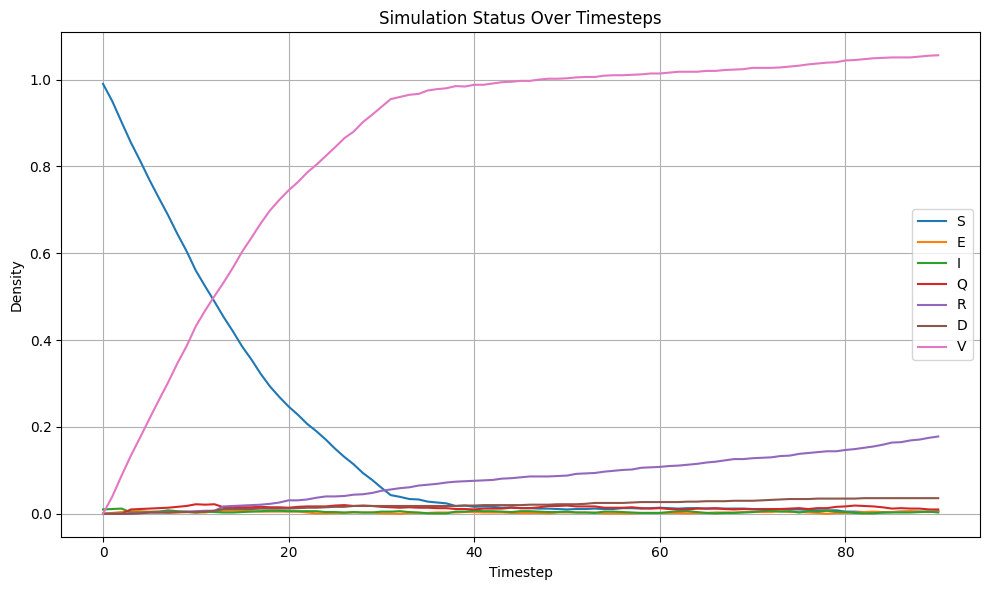

In [17]:
scon.plot_status_summary_from_hdf5("simulation_output.h5")

In [18]:
scon.visualize_folks_on_map_from_sim("simulation_output.h5", town_graph_path)

Extra block to clean up all the files produced from running the example

In [19]:
file_patterns = ["*.json", "*.graphmlz", "simulation_output.h5"]

removed_count = 0
for pattern in file_patterns:
    matching_files = glob.glob(pattern)
    for file_path in matching_files:
        try:
            os.remove(file_path)
            print(f"Removed: {file_path}")
            removed_count += 1
        except Exception as e:
            print(f"Failed to remove {file_path}: {e}")

Removed: cologne_config.json
Removed: herzogenrath_config.json
Removed: town_graph_config.json
Removed: cologne.graphmlz
Removed: herzogenrath.graphmlz
Removed: town_graph.graphmlz
Removed: simulation_output.h5
